In [1]:
import ccxt
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import matplotlib.pyplot as plt

import json
import time
import os
import sys

In [2]:
src_path = '../src/'
sys.path.append(os.path.abspath(src_path))
from func_get import *
from func_signal import *
from func_backtest import *

In [3]:
start_ts = time.time()

In [4]:
interval_dict = {
    '1m': 1,
    '5m': 5,
    '15m': 15,
    '30m': 30,
    '1h': 60,
    '2h': 120,
    '4h': 240,
    '1d': 1440
}

In [5]:
with open('../../../_keys/ftx/ftx_read_keys.json') as keys_file:
    keys_dict = json.load(keys_file)
    
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

### Config

In [6]:
project_name = 'messi_revert'

In [7]:
start_date = dt.datetime(2021, 1, 1)
start_hour = 1
end_date = dt.datetime.today() - dt.timedelta(days=1)
reinvest_profit_flag = True

In [8]:
config_params = {
    'safety_ohlcv_range': 1000,
    'action_timeframe': '2h',
    'base': {
        'symbol': ['ETH-PERP'],
        'open': {
            '2h': {
                'tma': {
                    'check': [check_signal_side_change],
                    'look_back': 1,
                    'windows': 50,
                    'revert': True
                }
            }
        },
        'close': {
            '2h': {
                'tma': {
                    'check': [check_signal_side],
                    'look_back': 1,
                    'windows': 50,
                    'revert': True
                }
            }
        }
    },
    'lead': {
        'symbol': [],
        'open': {
        },
        'close': {
        }
    },
    'tp': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None,
    },
    'sl': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None
    },
    'action_percent': 100,
    'leverage': 1,
    'taker_fee_percent': 0.07
}

### Get data

In [9]:
ohlcv_df_dict = get_data(exchange, start_date, end_date, start_hour, interval_dict, config_params)

base: timeframe 1/1 symbol 1/1 date 1/599
base: timeframe 1/1 symbol 1/1 date 2/599
base: timeframe 1/1 symbol 1/1 date 3/599
base: timeframe 1/1 symbol 1/1 date 4/599
base: timeframe 1/1 symbol 1/1 date 5/599
base: timeframe 1/1 symbol 1/1 date 6/599
base: timeframe 1/1 symbol 1/1 date 7/599
base: timeframe 1/1 symbol 1/1 date 8/599
base: timeframe 1/1 symbol 1/1 date 9/599
base: timeframe 1/1 symbol 1/1 date 10/599
base: timeframe 1/1 symbol 1/1 date 11/599
base: timeframe 1/1 symbol 1/1 date 12/599
base: timeframe 1/1 symbol 1/1 date 13/599
base: timeframe 1/1 symbol 1/1 date 14/599
base: timeframe 1/1 symbol 1/1 date 15/599
base: timeframe 1/1 symbol 1/1 date 16/599
base: timeframe 1/1 symbol 1/1 date 17/599
base: timeframe 1/1 symbol 1/1 date 18/599
base: timeframe 1/1 symbol 1/1 date 19/599
base: timeframe 1/1 symbol 1/1 date 20/599
base: timeframe 1/1 symbol 1/1 date 21/599
base: timeframe 1/1 symbol 1/1 date 22/599
base: timeframe 1/1 symbol 1/1 date 23/599
base: timeframe 1/1 

base: timeframe 1/1 symbol 1/1 date 190/599
base: timeframe 1/1 symbol 1/1 date 191/599
base: timeframe 1/1 symbol 1/1 date 192/599
base: timeframe 1/1 symbol 1/1 date 193/599
base: timeframe 1/1 symbol 1/1 date 194/599
base: timeframe 1/1 symbol 1/1 date 195/599
base: timeframe 1/1 symbol 1/1 date 196/599
base: timeframe 1/1 symbol 1/1 date 197/599
base: timeframe 1/1 symbol 1/1 date 198/599
base: timeframe 1/1 symbol 1/1 date 199/599
base: timeframe 1/1 symbol 1/1 date 200/599
base: timeframe 1/1 symbol 1/1 date 201/599
base: timeframe 1/1 symbol 1/1 date 202/599
base: timeframe 1/1 symbol 1/1 date 203/599
base: timeframe 1/1 symbol 1/1 date 204/599
base: timeframe 1/1 symbol 1/1 date 205/599
base: timeframe 1/1 symbol 1/1 date 206/599
base: timeframe 1/1 symbol 1/1 date 207/599
base: timeframe 1/1 symbol 1/1 date 208/599
base: timeframe 1/1 symbol 1/1 date 209/599
base: timeframe 1/1 symbol 1/1 date 210/599
base: timeframe 1/1 symbol 1/1 date 211/599
base: timeframe 1/1 symbol 1/1 d

base: timeframe 1/1 symbol 1/1 date 377/599
base: timeframe 1/1 symbol 1/1 date 378/599
base: timeframe 1/1 symbol 1/1 date 379/599
base: timeframe 1/1 symbol 1/1 date 380/599
base: timeframe 1/1 symbol 1/1 date 381/599
base: timeframe 1/1 symbol 1/1 date 382/599
base: timeframe 1/1 symbol 1/1 date 383/599
base: timeframe 1/1 symbol 1/1 date 384/599
base: timeframe 1/1 symbol 1/1 date 385/599
base: timeframe 1/1 symbol 1/1 date 386/599
base: timeframe 1/1 symbol 1/1 date 387/599
base: timeframe 1/1 symbol 1/1 date 388/599
base: timeframe 1/1 symbol 1/1 date 389/599
base: timeframe 1/1 symbol 1/1 date 390/599
base: timeframe 1/1 symbol 1/1 date 391/599
base: timeframe 1/1 symbol 1/1 date 392/599
base: timeframe 1/1 symbol 1/1 date 393/599
base: timeframe 1/1 symbol 1/1 date 394/599
base: timeframe 1/1 symbol 1/1 date 395/599
base: timeframe 1/1 symbol 1/1 date 396/599
base: timeframe 1/1 symbol 1/1 date 397/599
base: timeframe 1/1 symbol 1/1 date 398/599
base: timeframe 1/1 symbol 1/1 d

base: timeframe 1/1 symbol 1/1 date 565/599
base: timeframe 1/1 symbol 1/1 date 566/599
base: timeframe 1/1 symbol 1/1 date 567/599
base: timeframe 1/1 symbol 1/1 date 568/599
base: timeframe 1/1 symbol 1/1 date 569/599
base: timeframe 1/1 symbol 1/1 date 570/599
base: timeframe 1/1 symbol 1/1 date 571/599
base: timeframe 1/1 symbol 1/1 date 572/599
base: timeframe 1/1 symbol 1/1 date 573/599
base: timeframe 1/1 symbol 1/1 date 574/599
base: timeframe 1/1 symbol 1/1 date 575/599
base: timeframe 1/1 symbol 1/1 date 576/599
base: timeframe 1/1 symbol 1/1 date 577/599
base: timeframe 1/1 symbol 1/1 date 578/599
base: timeframe 1/1 symbol 1/1 date 579/599
base: timeframe 1/1 symbol 1/1 date 580/599
base: timeframe 1/1 symbol 1/1 date 581/599
base: timeframe 1/1 symbol 1/1 date 582/599
base: timeframe 1/1 symbol 1/1 date 583/599
base: timeframe 1/1 symbol 1/1 date 584/599
base: timeframe 1/1 symbol 1/1 date 585/599
base: timeframe 1/1 symbol 1/1 date 586/599
base: timeframe 1/1 symbol 1/1 d

### Add signal

In [10]:
ohlcv_df_dict = add_signal(start_date, ohlcv_df_dict, interval_dict, config_params)

base add tma to ETH-PERP 2h


### Back test

In [11]:
action_time_list = gen_action_time_list(config_params, ohlcv_df_dict)
max_open_timeframe = get_max_open_timeframe(config_params, interval_dict)

In [12]:
budget = 100

transaction_dict = {
    'symbol': [],
    'side': [],
    'amount': [],
    'open_time': [],
    'open_price': [],
    'close_time': [],
    'close_price': [],
    'value': [],
    'notional': [],
    'profit': [],
    'profit_percent': []
}

position_dict = {}

if reinvest_profit_flag == True:
    budget_dict = {
        'time': [],
        'budget': []
    }
    
max_drawdown = 0

In [13]:
if reinvest_profit_flag == True:
    min_budget = budget

time_count = 0

for signal_time in action_time_list:
    action_time = signal_time + dt.timedelta(minutes=interval_dict[config_params['action_timeframe']])
    
    time_count += 1
    print(f"Time {action_time}: progress {time_count}/{len(action_time_list)}")

    '''
    Close positions
    '''
    for symbol in [x for x in position_dict.keys()]:
        print(f"  {symbol}")
        budget, max_drawdown, position_dict, transaction_dict = close_position(symbol, signal_time, max_drawdown, config_params, budget, reinvest_profit_flag, ohlcv_df_dict, position_dict, transaction_dict, interval_dict)

    '''
    Open positions
    '''
    max_position = int(1 / (config_params['action_percent'] / 100))

    for symbol in [x for x in config_params['base']['symbol'] if x not in position_dict.keys()][:max_position]:
        print(f"  {symbol}")
        position_dict = open_position(symbol, signal_time, max_open_timeframe, config_params, budget, ohlcv_df_dict, position_dict, interval_dict)    
    
    '''
    Update budget
    '''
    if reinvest_profit_flag == True:
        budget_dict['time'].append(signal_time)
        budget_dict['budget'].append(budget)

        if budget < min_budget:
            min_budget = budget

    if budget <= 0:
        print(f"Out of money at {action_time}")
        break
        
'''
Clear final position
'''
opened_symbol = list(position_dict.keys())

for symbol in opened_symbol:
    print(f" Clear {symbol} position")
    
    side = position_dict[symbol]['side']
    ohlcv_df = ohlcv_df_dict['base'][config_params['action_timeframe']][symbol]
    current_ohlcv_df = ohlcv_df[ohlcv_df['time'] == signal_time].reset_index(drop=True)
    close_price = current_ohlcv_df.loc[0, 'close']
    close_percent = 100
    
    budget, position_dict, transaction_dict = update_close_position(symbol, side, close_price, close_percent, signal_time, config_params, budget, reinvest_profit_flag, position_dict, transaction_dict, interval_dict)

Time 2021-01-01 03:00:00: progress 1/5184
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 05:00:00: progress 2/5184
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 07:00:00: progress 3/5184
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 09:00:00: progress 4/5184
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 11:00:00: progress 5/5184
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 13:00:00: progress 6/5184
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 15:00:00: progress 7/5184
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: no_action
     No action
Time 2021-01-01 17:00:00: progress 8/5184
  ETH-PERP
     base ETH-PERP check_signal_side_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-17 19:00:00: progress 201/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 1220.7
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.03494414868104345
     price: 1220.7
     tp: 0
     sl: inf
Time 2021-01-17 21:00:00: progress 202/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-17 23:00:00: progress 203/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-18 01:00:00: progress 204/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-18 03:00:00: progress 205/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-18 05:00:00: progress 206/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-01-18 07:00:00: progress 207/5184
  ETH-PERP
  

     Not close
Time 2021-01-23 03:00:00: progress 265/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-23 05:00:00: progress 266/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-23 07:00:00: progress 267/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-23 09:00:00: progress 268/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-23 11:00:00: progress 269/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-23 13:00:00: progress 270/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-23 15:00:00: progress 271/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-23 17:00:00: progress 272/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-01-23 19:00:00: progres

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-04 01:00:00: progress 408/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-04 03:00:00: progress 409/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-04 05:00:00: progress 410/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-04 07:00:00: progress 411/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-04 09:00:00: progress 412/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-04 11:00:00: progress 413/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-04 13:00:00: progress 414/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-04 15:00:00: progress 415/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma

Time 2021-02-10 19:00:00: progress 489/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-10 21:00:00: progress 490/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-10 23:00:00: progress 491/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-11 01:00:00: progress 492/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-11 03:00:00: progress 493/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-11 05:00:00: progress 494/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-11 07:00:00: progress 495/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-02-11 09:00:00: progress 496/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 1709.3
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.022619170251656603
     price: 1922.4
     tp: inf
     sl: 0
Time 2021-02-22 07:00:00: progress 627/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-22 09:00:00: progress 628/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-22 11:00:00: progress 629/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-22 13:00:00: progress 630/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-22 15:00:00: progress 631/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-22 17:00:00: progress 632/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-22 19:00:00: progress 633/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-02-22 21:00:00: progress 63

  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 1506.0
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.022583125567524107
     price: 1506.0
     tp: 0
     sl: inf
Time 2021-03-01 19:00:00: progress 717/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-01 21:00:00: progress 718/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-01 23:00:00: progress 719/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-02 01:00:00: progress 720/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-02 03:00:00: progress 721/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-02 05:00:00: progress 722/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-02 07:00:00: progress 723/5184


     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-03-13 19:00:00: progress 861/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 1873.8
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.019523306079074126
     price: 1873.8
     tp: 0
     sl: inf
Time 2021-03-13 21:00:00: progress 862/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-13 23:00:00: progress 863/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-14 01:00:00: progress 864/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-14 03:00:00: progress 865/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-14 05:00:00: progress 866/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-14 07:00:00: progress 867/5184
  ETH-PERP
 

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-20 11:00:00: progress 941/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-20 13:00:00: progress 942/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-20 15:00:00: progress 943/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-20 17:00:00: progress 944/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-20 19:00:00: progress 945/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-20 21:00:00: progress 946/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-20 23:00:00: progress 947/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-03-21 01:00:00: progress 948/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-03 01:00:00: progress 1104/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-03 03:00:00: progress 1105/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-03 05:00:00: progress 1106/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-03 07:00:00: progress 1107/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-03 09:00:00: progress 1108/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-03 11:00:00: progress 1109/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-03 13:00:00: progress 1110/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-03 15:00:00: progress 1111/5184
  ETH-PERP
     base ETH-PERP check_signal_

     Closed by signal at 2083.4
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.014587260464742164
     price: 2083.4
     tp: 0
     sl: inf
Time 2021-04-09 09:00:00: progress 1180/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-09 11:00:00: progress 1181/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-09 13:00:00: progress 1182/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-09 15:00:00: progress 1183/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-09 17:00:00: progress 1184/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-09 19:00:00: progress 1185/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-04-09 21:00:00: progress 1186/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-19 09:00:00: progress 1300/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-19 11:00:00: progress 1301/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-19 13:00:00: progress 1302/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-19 15:00:00: progress 1303/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-19 17:00:00: progress 1304/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-19 19:00:00: progress 1305/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-19 21:00:00: progress 1306/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-19 23:00:00: progress 1307/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-25 09:00:00: progress 1372/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-25 11:00:00: progress 1373/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-25 13:00:00: progress 1374/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-25 15:00:00: progress 1375/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-25 17:00:00: progress 1376/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-25 19:00:00: progress 1377/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-25 21:00:00: progress 1378/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-04-25 23:00:00: progress 1379/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-08 13:00:00: progress 1530/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-08 15:00:00: progress 1531/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-08 17:00:00: progress 1532/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-08 19:00:00: progress 1533/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-08 21:00:00: progress 1534/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-08 23:00:00: progress 1535/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-09 01:00:00: progress 1536/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-09 03:00:00: progress 1537/5184
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-15 01:00:00: progress 1608/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-15 03:00:00: progress 1609/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-15 05:00:00: progress 1610/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-15 07:00:00: progress 1611/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-15 09:00:00: progress 1612/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-15 11:00:00: progress 1613/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-15 13:00:00: progress 1614/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-15 15:00:00: progress 1615/5184
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-27 07:00:00: progress 1755/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-27 09:00:00: progress 1756/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-27 11:00:00: progress 1757/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-27 13:00:00: progress 1758/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-27 15:00:00: progress 1759/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-27 17:00:00: progress 1760/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-27 19:00:00: progress 1761/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-05-27 21:00:00: progress 1762/5184
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-02 09:00:00: progress 1828/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-02 11:00:00: progress 1829/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-02 13:00:00: progress 1830/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-02 15:00:00: progress 1831/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-02 17:00:00: progress 1832/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-02 19:00:00: progress 1833/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-02 21:00:00: progress 1834/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-02 23:00:00: progress 1835/5184
  ETH-PERP
     base ETH-PERP check_signal_

Time 2021-06-17 11:00:00: progress 2009/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-17 13:00:00: progress 2010/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-17 15:00:00: progress 2011/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-17 17:00:00: progress 2012/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-17 19:00:00: progress 2013/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-17 21:00:00: progress 2014/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-17 23:00:00: progress 2015/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-18 01:00:00: progress 2016/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-18 03:00:00: progress 2017/

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-24 11:00:00: progress 2093/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-24 13:00:00: progress 2094/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-24 15:00:00: progress 2095/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-24 17:00:00: progress 2096/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-06-24 19:00:00: progress 2097/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 1966.1
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.0023454104492008493
     price: 1966.1
     tp: 0
     sl: inf
Time 2021-06-24 21:00:00: progress 2098/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-06-24 23:00:00: progress 2099/5184
  ETH-PE

  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-07 05:00:00: progress 2246/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-07 07:00:00: progress 2247/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-07 09:00:00: progress 2248/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-07 11:00:00: progress 2249/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-07 13:00:00: progress 2250/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-07 15:00:00: progress 2251/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-07 17:00:00: progress 2252/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-07 19:00:00: progress 2253/5184
  ETH-PERP
     base ETH-PERP ch

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-26 03:00:00: progress 2473/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-26 05:00:00: progress 2474/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-26 07:00:00: progress 2475/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-26 09:00:00: progress 2476/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-26 11:00:00: progress 2477/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-26 13:00:00: progress 2478/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-26 15:00:00: progress 2479/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-07-26 17:00:00: progress 2480/5184
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 3228.4
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.0010227544576525518
     price: 3228.4
     tp: 0
     sl: inf
Time 2021-08-13 17:00:00: progress 2696/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-13 19:00:00: progress 2697/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-13 21:00:00: progress 2698/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-13 23:00:00: progress 2699/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-14 01:00:00: progress 2700/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-14 03:00:00: progress 2701/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-14 05:00:00: progress 2702/5184
  E

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-31 19:00:00: progress 2913/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-31 21:00:00: progress 2914/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-08-31 23:00:00: progress 2915/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-01 01:00:00: progress 2916/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-01 03:00:00: progress 2917/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-01 05:00:00: progress 2918/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-01 07:00:00: progress 2919/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-09-01 09:00:00: progress 2920/5184
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-19 13:00:00: progress 3138/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-19 15:00:00: progress 3139/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-19 17:00:00: progress 3140/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-19 19:00:00: progress 3141/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-19 21:00:00: progress 3142/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-19 23:00:00: progress 3143/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-20 01:00:00: progress 3144/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-09-20 03:00:00: progress 3145/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-05 05:00:00: progress 3326/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-05 07:00:00: progress 3327/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-05 09:00:00: progress 3328/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-05 11:00:00: progress 3329/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-05 13:00:00: progress 3330/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-05 15:00:00: progress 3331/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-05 17:00:00: progress 3332/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-05 19:00:00: progress 3333/5184
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: sell
     Closed by signal at 4081.2
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: sell
     sell: 0.000625925766121297
     price: 4081.2
     tp: 0
     sl: inf
Time 2021-10-25 07:00:00: progress 3567/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-25 09:00:00: progress 3568/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-25 11:00:00: progress 3569/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-25 13:00:00: progress 3570/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-25 15:00:00: progress 3571/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-25 17:00:00: progress 3572/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-10-25 19:00:00: progress 3573/5184
  ET

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-10 23:00:00: progress 3767/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-11 01:00:00: progress 3768/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-11-11 03:00:00: progress 3769/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 4701.7
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.0005646153010179267
     price: 4701.7
     tp: inf
     sl: 0
Time 2021-11-11 05:00:00: progress 3770/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-11 07:00:00: progress 3771/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-11 09:00:00: progress 3772/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-11 11:00:00: progress 3773/5184
  ETH-PER

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-27 03:00:00: progress 3961/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-27 05:00:00: progress 3962/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-27 07:00:00: progress 3963/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-27 09:00:00: progress 3964/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-27 11:00:00: progress 3965/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-27 13:00:00: progress 3966/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-27 15:00:00: progress 3967/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-11-27 17:00:00: progress 3968/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-13 07:00:00: progress 4155/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2021-12-13 09:00:00: progress 4156/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 3969.2
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.0006944538750626191
     price: 3969.2
     tp: inf
     sl: 0
Time 2021-12-13 11:00:00: progress 4157/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-12-13 13:00:00: progress 4158/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-12-13 15:00:00: progress 4159/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-12-13 17:00:00: progress 4160/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2021-12-13 19:00:00: progress 4161/5184
  ETH-PERP

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-01 01:00:00: progress 4380/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Closed by signal at 3722.9
  ETH-PERP
     base ETH-PERP check_signal_side_change tma 2h: buy
     buy: 0.0008698352114786601
     price: 3722.9
     tp: inf
     sl: 0
Time 2022-01-01 03:00:00: progress 4381/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-01 05:00:00: progress 4382/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-01 07:00:00: progress 4383/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-01 09:00:00: progress 4384/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-01 11:00:00: progress 4385/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-01-01 13:00:00: progress 4386/5184
  ETH-PERP


     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-15 23:00:00: progress 4559/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-16 01:00:00: progress 4560/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-16 03:00:00: progress 4561/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-16 05:00:00: progress 4562/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-16 07:00:00: progress 4563/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-16 09:00:00: progress 4564/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-16 11:00:00: progress 4565/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-16 13:00:00: progress 4566/5184
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-31 19:00:00: progress 4749/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-31 21:00:00: progress 4750/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-01-31 23:00:00: progress 4751/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-01 01:00:00: progress 4752/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-01 03:00:00: progress 4753/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-01 05:00:00: progress 4754/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-01 07:00:00: progress 4755/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-01 09:00:00: progress 4756/5184
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-16 11:00:00: progress 4937/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-16 13:00:00: progress 4938/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-16 15:00:00: progress 4939/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-16 17:00:00: progress 4940/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-16 19:00:00: progress 4941/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-16 21:00:00: progress 4942/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-16 23:00:00: progress 4943/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: sell
     Not close
Time 2022-02-17 01:00:00: progress 4944/5184
  ETH-PERP
     base ETH-PERP check_signal_

     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-06 05:00:00: progress 5150/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-06 07:00:00: progress 5151/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-06 09:00:00: progress 5152/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-06 11:00:00: progress 5153/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-06 13:00:00: progress 5154/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-06 15:00:00: progress 5155/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-06 17:00:00: progress 5156/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma 2h: buy
     Not close
Time 2022-03-06 19:00:00: progress 5157/5184
  ETH-PERP
     base ETH-PERP check_signal_side tma

In [14]:
end_ts = time.time()
time_process = end_ts - start_ts
print(f"Time process: {round(time_process / 60, 2)} minutes")

Time process: 2.07 minutes


### Result

In [15]:
transaction_df = pd.DataFrame(transaction_dict)
transaction_df.to_csv(f'transactions/{project_name}.csv', index=False)
transaction_df

,symbol,side,amount,open_time,open_price,close_time,close_price,value,notional,profit,profit_percent
0,ETH-PERP,buy,0.137061,2021-01-02 01:00:00,729.60,2021-01-02 21:00:00,773.76,100.000000,100.000000,5.908395,5.904262
1,ETH-PERP,sell,0.136875,2021-01-02 21:00:00,773.76,2021-01-11 09:00:00,1211.50,105.908395,105.908395,-60.105872,-56.792453
2,ETH-PERP,buy,0.037806,2021-01-11 09:00:00,1211.50,2021-01-14 05:00:00,1128.80,45.802523,45.802523,-3.188529,-6.956600
3,ETH-PERP,sell,0.037752,2021-01-14 05:00:00,1128.80,2021-01-14 11:00:00,1097.00,42.613994,42.613994,1.141681,2.681000
4,ETH-PERP,buy,0.039887,2021-01-14 11:00:00,1097.00,2021-01-14 13:00:00,1111.10,43.755675,43.755675,0.500750,1.143623
...,...,...,...,...,...,...,...,...,...,...,...
268,ETH-PERP,buy,0.000797,2022-02-25 07:00:00,2597.00,2022-02-25 09:00:00,2630.60,2.069394,2.069394,0.023858,1.152088
269,ETH-PERP,sell,0.000796,2022-02-25 09:00:00,2630.60,2022-02-28 03:00:00,2606.40,2.093252,2.093252,0.016340,0.781133
270,ETH-PERP,buy,0.000809,2022-02-28 03:00:00,2606.40,2022-02-28 23:00:00,2817.30,2.109591,2.109591,0.167627,7.940398
271,ETH-PERP,sell,0.000808,2022-02-28 23:00:00,2817.30,2022-03-03 23:00:00,2828.70,2.277219,2.277219,-0.012409,-0.545308


In [16]:
if reinvest_profit_flag == True:
    print(f"Final budget: {round(budget, 2)}")
else:
    print("Not reinvest profit")

Final budget: 2.07


In [17]:
if reinvest_profit_flag == True:
    return_percent = (budget_dict['budget'][-1] - budget_dict['budget'][0]) / budget_dict['budget'][0] * 100
    print(f"Return: {round(return_percent, 2)}%")
else:
    print("Not reinvest profit")

Return: -97.74%


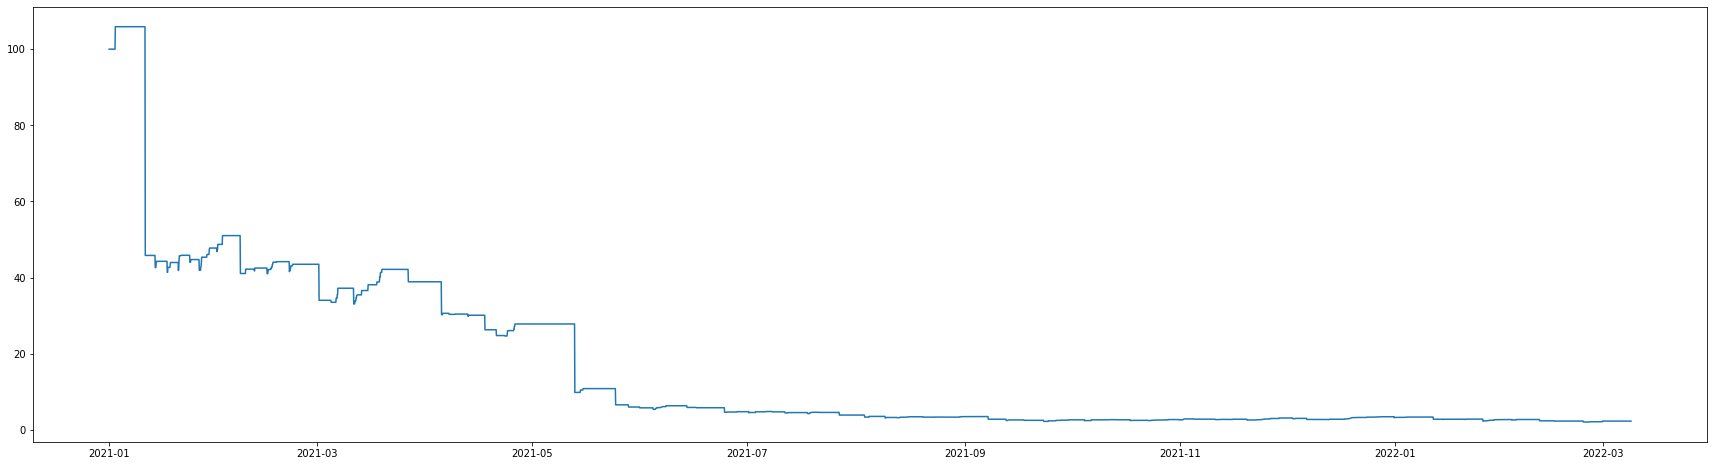

In [18]:
if reinvest_profit_flag == True:
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(budget_dict['time'], budget_dict['budget'])
else:
    print("Not reinvest profit")

In [19]:
if reinvest_profit_flag == True:
    print(f"Max drawdown: {round(max_drawdown * 100, 2)}%")

Max drawdown: 88.69%


In [20]:
win_rate = len(transaction_df[transaction_df['profit'] > 0]) / len(transaction_df)
print(f"Win rate: {round(win_rate * 100, 2)}%")

Win rate: 71.06%


In [21]:
for symbol in transaction_df['symbol'].unique():
    symbol_df = transaction_df[transaction_df['symbol'] == symbol]
    win_rate = len(symbol_df[symbol_df['profit'] > 0]) / len(symbol_df)
    print(f"{symbol} win rate: {round(win_rate * 100, 2)}%")

ETH-PERP win rate: 71.06%


In [22]:
print(f"Distribution")
print(pd.DataFrame(transaction_df['profit_percent'].describe()))

Distribution
       profit_percent
count      273.000000
mean        -1.007371
std          7.468250
min        -64.739527
25%         -0.545308
50%          0.871333
75%          1.901466
max          7.940398


In [23]:
for symbol in transaction_df['symbol'].unique():
    temp_return = transaction_df[transaction_df['symbol'] == symbol]['profit_percent']
    
    print(f"Distribution {symbol}:")
    print(pd.DataFrame(temp_return.describe()))
    print("\n")

Distribution ETH-PERP:
       profit_percent
count      273.000000
mean        -1.007371
std          7.468250
min        -64.739527
25%         -0.545308
50%          0.871333
75%          1.901466
max          7.940398




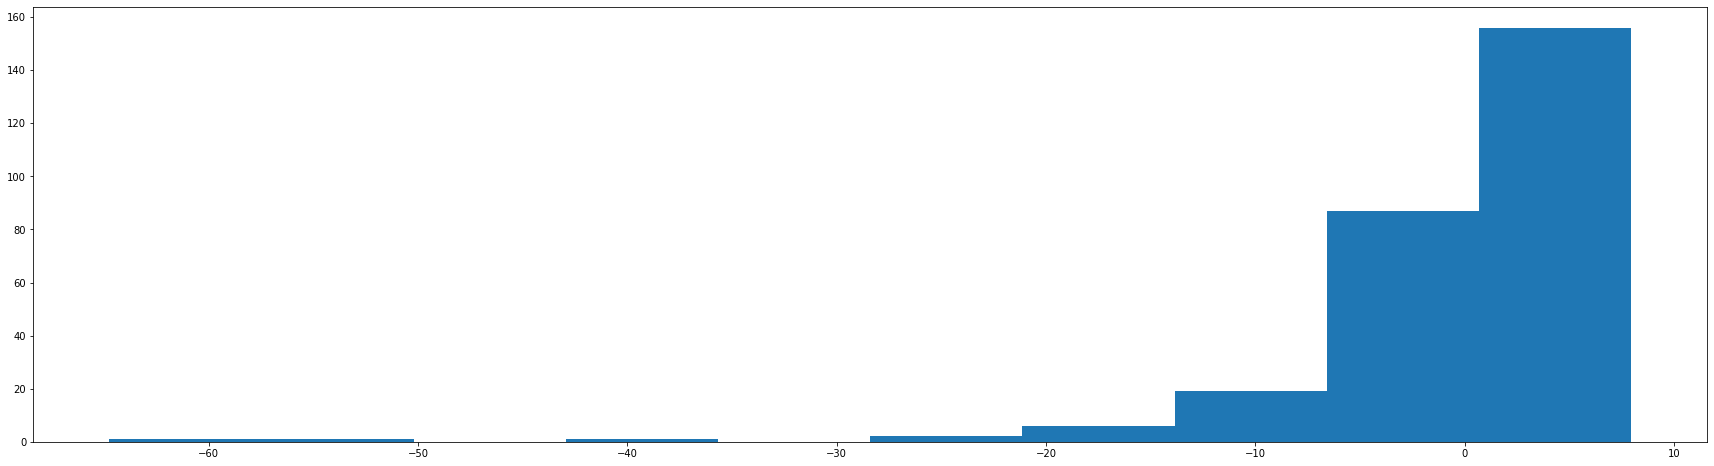

In [24]:
fig, ax = plt.subplots(figsize=(30, 8))
_ = ax.hist(transaction_df['profit_percent'], bins=10)